<a href="https://colab.research.google.com/github/peternguyen24/NeuralNetworkBasic/blob/main/language/training_name_model_NN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video: https://www.youtube.com/watch?v=TCH_1BHY58I&t=308s

In [70]:
 words = open('/content/drive/MyDrive/Colab Notebooks/names.txt', 'r').read().splitlines()

In [71]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

#Part 1: Dataset

In [72]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [73]:
chars = set()
for word in words:
  for ch in word:
    chars.add(ch)
chars = sorted(list(chars))

stoi = {ch: idx+1 for idx, ch in enumerate(chars)}
stoi['.'] = 0

itos = {idx: ch for ch, idx in stoi.items()}
print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [74]:
# BLOCK_SIZE = 3
# X, Y  = [], []

# for w in words:
#   # print(w)
#   context = [0] * BLOCK_SIZE
#   for ch in w + '.':
#     ix = stoi[ch]
#     X.append(context)
#     Y.append(ix)
#     # print(''.join(itos[i] for i in context), '--->', itos[ix])
#     context = context[1:] + [ix]

# X = torch.tensor(X)
# Y = torch.tensor(Y)
# data_size = X.nelement()

In [75]:
# X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [105]:
# training split, validation split, test split
# 80% 10% 10%

BLOCK_SIZE = 3

def build_dataset(words):
  X, Y  = [], []
  for w in words:
  # print(w)
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]
  return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


# Training


In [159]:
def train_nn(X, Y, neuron_count=100, embedding_size = 2):
  g = torch.Generator().manual_seed(2147483647)
  C = torch.randn((27, embedding_size), generator=g)
  W1 = torch.rand((3*embedding_size, neuron_count), generator=g) # input is 6, since each input is 3 words x 2 embedding vector size
  b1 = torch.randn(neuron_count, generator=g)
  W2 = torch.randn((neuron_count, 27), generator=g)
  b2 = torch.randn(27, generator=g)

  parameters = [C, W1, b1, W2, b2]

  print("Number of parameter: ", sum(p.nelement() for p in parameters))

  # emb.shape # [<number.of.input>, 3, 2] means each 32 input, each input is 3 char, each char is 2-dim vector

  for p in parameters: # don't forget to clear params grad every time.
      p.requires_grad = True

  for step in range(30000):

    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward
    emb = C[X[ix]] # transform words to embedding
    # neuron layer #1. Input 6 output 100; (* input size)
    h = torch.tanh(emb.view(-1, embedding_size * 3) @ W1 + b1)
    # neuron layer #2. Input 100 output 27; (* input size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())


    # Backward
    for p in parameters: # don't forget to clear params grad every time.
      p.grad = None
    loss.backward()

    # update
    LR = 0.04 # Good technique is to find a good number, then after training, decay it by 10, then run couple more time.
    for p in parameters:
      p.data += -LR * p.grad

  print("Final loss: ", loss.item())
  return C, W1, b1, W2, b2



In [163]:
C, W1, b1, W2, b2 = train_nn(Xtr, Ytr, neuron_count = 200, embedding_size = 10)
model_params = [C, W1, b1, W2, b2]

Number of parameter:  11897
Final loss:  1.9969549179077148


In [161]:
# Evaluation on whole data (dev set)

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.330176830291748


In [152]:
# Evaluation on whole data (training set)

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.4213690757751465


In [162]:
# Evaluation on whole data (test set)

emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.3309710025787354


# How to adjust learning rate

How to get the right learning rate:

- Try with small learning rate to see if things is moving
- Try with big learning rate to see if things explode

=> Result is between



In [77]:
# lre = torch.linspace(-3, 0, 1000) #-3, -2, -1, 0 => we want 10^x
# lrs = 10**lre

In [90]:
# for p in parameters:
#   p.requires_grad = True

In [83]:
# emb.shape # [<number.of.input>, 3, 2] means each 32 input, each input is 3 char, each char is 2-dim vector

# TRAINING FOR PURPOSE OF FINDING STEP. DONOT RUN

lri = []
lossi = []

for step in range(1000):

  # minibatch
  ix = torch.randint(0, X.shape[0], (128,))

  # Forward
  emb = C[X[ix]] # transform words to embedding
  # neuron layer #1. Input 6 output 100; (* input size)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  # neuron layer #2. Input 100 output 27; (* input size)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())


  # Backward
  for p in parameters: # don't forget to clear params grad every time.
    p.grad = None
  loss.backward()

  # update
  lr = lrs[step]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[step])
  lossi.append(loss.item())

print(loss.item())

plt.plot(lri, lossi)


6.702215194702148


In [ ]:
# Visualize the embeddings

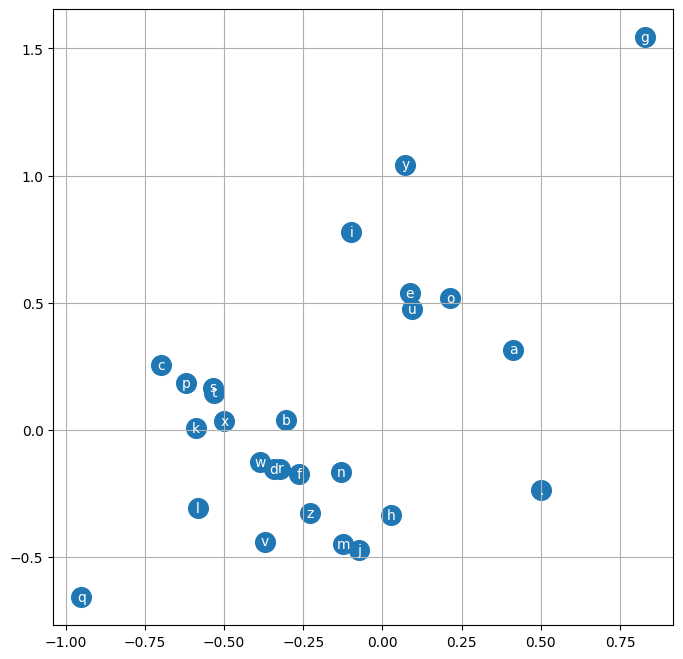

In [153]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# Predict (generate word)

In [232]:
def predict_next_ch(input = "..."):
  input_ix = [stoi[ch] for ch in input]
  emb = C[torch.tensor(input_ix)]
  h = torch.tanh(emb.view(1, -1) @ W1 + b1)
  logits = h @ W2 + b2
  probs = F.softmax(logits, dim=1)
  # find index of value bigger
  candidates = torch.topk(probs, 2).indices[0]
  return itos[candidates[random.randint(0,1)].item()]


for param in model_params:
    param.requires_grad = False
# predict_next_ch("cha")

#randomly create a name.

context = "tra"
name = [context]
for _ in range(20):
  next_ch = predict_next_ch(input = context)
  if next_ch == '.':
    break
  name.append(next_ch)
  context = context[1:] + next_ch
print("".join(name))



tran
